In [1]:
# cd /home/vule/projects/course22p2

## Load data

In [2]:
import logging
logging.disable(logging.WARNING)

In [3]:
from datasets import load_dataset,load_dataset_builder
import torch
import torchvision.transforms.functional as TF
from miniai.datasets import *

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)).view(-1, 28, 28) for o in b[x]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

/home/vule/miniconda3/envs/miniai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(torch.Size([1024, 1, 28, 28]), tensor([5, 3, 3, 7, 3, 8, 7, 4, 2, 4]))

## Create sequence

In [4]:
from miniai.conv import conv
from torch import nn

layers = [conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten()]


## Create model

In [5]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self, layers):
        super(TinyModel, self).__init__()
        self.layers = nn.Sequential(*layers)
        self.means = [[] for _ in self.layers]
        self.stds = [[] for _ in self.layers]
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            self.means[i].append(x.mean().item())
            self.stds[i].append(x.std().item())
        return x

model = TinyModel(layers)

In [6]:
# model(xb)
# model.means

accuracy,loss,epoch,train
0.106,2.346,0,train
0.100,2.305,0,eval


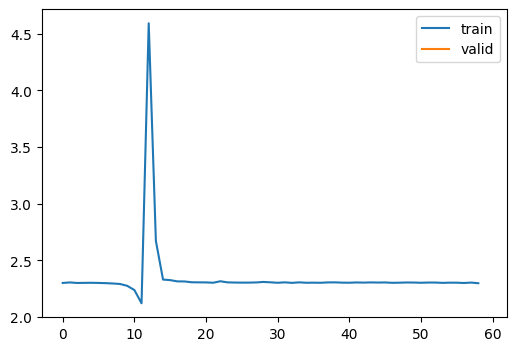

In [7]:
from miniai.learner import Learner, TrainCB, DeviceCB, MetricsCB, ProgressCB
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy,Mean

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=2, cbs=cbs)
learn.fit(1)

## plot mean std

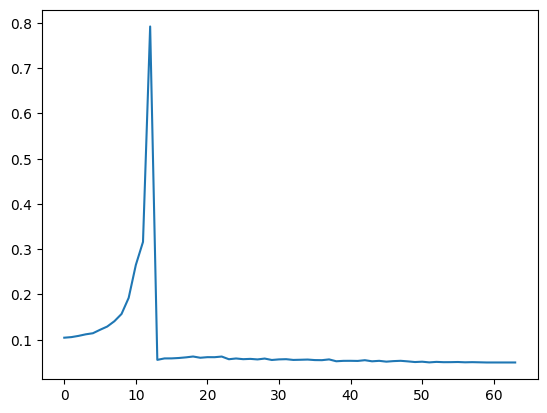

In [20]:
import matplotlib.pyplot as plt

x = [1, 2, 3, 4, 7]
# y = [2, 4, 1, 5, 2]

plt.plot(model.means[1])
plt.show()

In [9]:
# plot histogram

In [10]:
# hook

In [11]:
# context manager